In [511]:
%matplotlib inline
import os, sys, gc
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML

In [512]:
load_dir = 'lo-shot-dinos-classification-genetic-pilot'
print(os.listdir(load_dir))

['b', 'html-button-response.csv', 'participants.csv', 'survey-multi-choice.csv']


## Building Dataframes

In [513]:
num=1
ignore = ['w93e05c8', 'w8f3a5e6', 'w72ff099', 'w6189e36', 'w3cbe79c',
       'w86d39ac', 'wfc8e96c', 'wf2fae6e', 'w2c152d2', 'wbfb9c6f',]
       #'wcfe7234', 'wb38724c', 'we815cde', 'wb2873cd', 'wf369503']
button_response_data = pd.read_csv("{}/html-button-response.csv".format(load_dir))
responses = button_response_data[(button_response_data.task == 'testing_c1_categorize') | (button_response_data.task == 'testing_c2_categorize')]
responses = responses[["wid", "task", "response", "target_dino", "label_pair", "manifold_jitter"]]
responses["response"] = responses["response"].astype('category',copy=False)
responses["target_dino"] = responses["target_dino"].astype('category',copy=False)
responses_test = responses[responses.label_pair == num]
responses_train = responses[responses.label_pair != num]
#responses=responses[responses.label_pair == num]
cloud1 = responses_test[responses_test.task == 'testing_c1_categorize']
cloud2 = responses_test[responses_test.task == 'testing_c2_categorize']
responses


,wid,task,response,target_dino,label_pair,manifold_jitter
9,w93e05c8,testing_c1_categorize,1,0.0,13,True
10,w93e05c8,testing_c1_categorize,2,18.0,13,True
11,w93e05c8,testing_c1_categorize,2,10.0,13,True
12,w93e05c8,testing_c1_categorize,1,8.0,13,True
13,w93e05c8,testing_c1_categorize,1,1.0,13,True
...,...,...,...,...,...,...
4153,wf902735,testing_c2_categorize,2,2.0,16,True
4154,wf902735,testing_c2_categorize,2,4.0,16,True
4155,wf902735,testing_c2_categorize,2,3.0,16,True
4156,wf902735,testing_c2_categorize,1,14.0,16,True


In [370]:
responses_train.groupby(['label_pair','wid',"target_dino",])['response'].count()!=0


label_pair  wid       target_dino
1           w01366f0  0.0            False
                      1.0            False
                      2.0            False
                      3.0            False
                      4.0            False
                                     ...  
13          wfc37f43  15.0           False
                      16.0           False
                      17.0           False
                      18.0           False
                      19.0           False
Name: response, Length: 9000, dtype: bool

In [509]:
def agreement(df1, df2):
    agreed=0
    for i in range(20):
        agreed+= set(df1[df1['target_dino']==i]['response'])==set(df2[df2['target_dino']==i]['response'])
    return agreed
subject_dfs=[]
for i in set(responses["label_pair"]):
    r=responses[responses["label_pair"]==i]
    wids=set(r["wid"])
    
    for w in wids:
        subject_dfs.append(r[r["wid"]==w])
print(len(subject_dfs[0]))
agreements=[]
for i in range(len(subject_dfs)):
    subj = subject_dfs[i]
    subjc1 = subj[subj.task == 'testing_c1_categorize']
    subjc2 = subj[subj.task == 'testing_c2_categorize']
#     plt.scatter(subjc1['target_dino'],subjc1['response'])
#     plt.show()
#     plt.scatter(subjc2['target_dino'],subjc2['response'])
#     plt.show()
    agreements.append(agreement(subjc1, subjc2))
print("Mean within-subject agreement between point clouds: {0}".format(np.mean(agreements)/20))

40
Mean within-subject agreement between point clouds: 0.7458333333333333


(0.5974814781738702, 1.6172459773555944e-177)


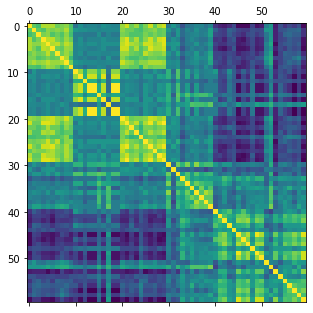

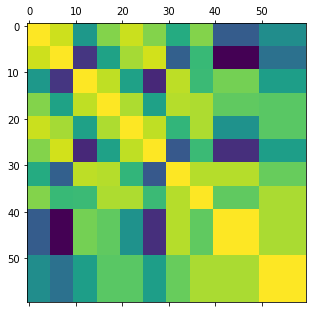

In [508]:
n=60
ags_mat1=np.empty((n,n))
ags_mat2=np.empty((n,n))

for i in range(n):
    for j in range(n):
        subj1=subject_dfs[i]
        subj2=subject_dfs[j]
        ags_mat1[i,j]=agreement(subj1[subj1.task == 'testing_c1_categorize'],subj2[subj2.task == 'testing_c1_categorize'])
        ags_mat2[i,j]=agreement(subj1[subj1.task == 'testing_c2_categorize'],subj2[subj2.task == 'testing_c2_categorize'])

plt.matshow(ags_mat1+ags_mat2)

lps=list(set(responses.label_pair))
label_similarity=np.empty((len(subject_dfs),len(subject_dfs)))
for i in range(len(subject_dfs)):
    for j in range(len(subject_dfs)):
        s1=subject_dfs[i]
        s2=subject_dfs[j]
        sl1=sl[list(s1.label_pair)[0]]
        sl2=sl[list(s2.label_pair)[0]]
        label_similarity[i,j]=np.sum((np.array(sl1)*np.array(sl2)))/(np.linalg.norm(sl1)*np.linalg.norm(sl2))#1/np.sum((np.array(sl[lps[i]])-np.array(sl[lps[j]]))**2)#1/(np.sum((np.array(sl1)-np.array(sl2))**2)+1)#
plt.matshow(label_similarity)
from scipy.stats import spearmanr, pearsonr
new_inds=np.triu_indices(60)
print(pearsonr((ags_mat1+ags_mat2)[new_inds].flatten(), label_similarity[new_inds].flatten()))

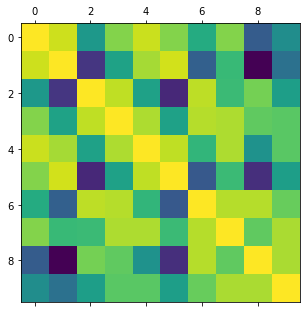

In [477]:
lps=list(set(responses.label_pair))
label_similarity=np.empty((len(lps),len(lps)))
for i in range(len(lps)):
    for j in range(len(lps)):
        label_similarity[i,j]=np.sum((np.array(sl[lps[i]])*np.array(sl[lps[j]])))/(np.linalg.norm(sl[lps[i]])*np.linalg.norm(sl[lps[j]]))#1/np.sum((np.array(sl[lps[i]])-np.array(sl[lps[j]]))**2)
plt.matshow(label_similarity)

(0.5974814781738702, 1.6172459773555944e-177)


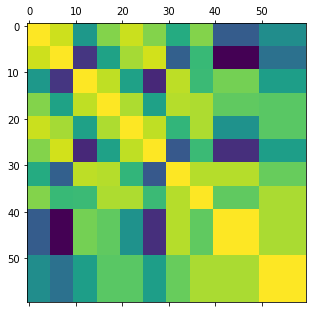

In [472]:
lps

[1, 2, 4, 5, 6, 7, 8, 9, 13, 14]

1
2
4
5
6
7
8
9
13
14


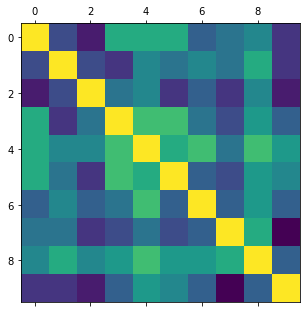

In [427]:
joint_mat=(ags_mat1+ags_mat2)/40
plt.matshow(joint_mat[:10,:10])
ags_mat=ags_mat1+ags_mat2
for i in set(responses.label_pair):
    print(i)

In [443]:
subject_dfs[-25]

,wid,task,response,target_dino,label_pair,manifold_jitter
2921,wfc37f43,testing_c1_categorize,0,18.0,9,True
2922,wfc37f43,testing_c1_categorize,2,8.0,9,True
2923,wfc37f43,testing_c1_categorize,1,1.0,9,True
2924,wfc37f43,testing_c1_categorize,0,15.0,9,True
2925,wfc37f43,testing_c1_categorize,1,9.0,9,True
2926,wfc37f43,testing_c1_categorize,0,11.0,9,True
2927,wfc37f43,testing_c1_categorize,0,17.0,9,True
2928,wfc37f43,testing_c1_categorize,2,7.0,9,True
2929,wfc37f43,testing_c1_categorize,0,16.0,9,True
2930,wfc37f43,testing_c1_categorize,2,6.0,9,True


In [400]:
set(agreements),[agreements.count(a) for a in set(agreements)]

({5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20},
 [1, 1, 2, 2, 1, 1, 3, 2, 5, 6, 4, 9, 6, 7, 3, 7])

<BarContainer object of 16 artists>

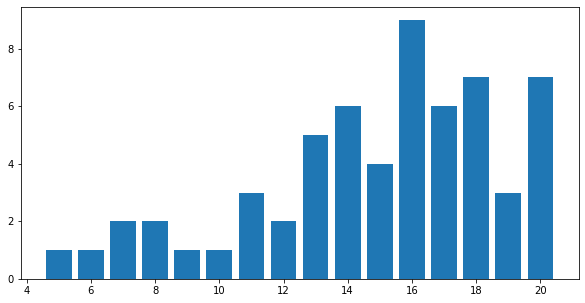

In [402]:
plt.bar(list(set(agreements)), [agreements.count(a) for a in set(agreements)])

In [394]:
np.mean(agreements)

14.916666666666666

In [ ]:
from numpy import array
sl =[[array([0., 0., 1.]), array([0.25, 0.25, 0.5 ])],
 [array([0., 0., 1.]), array([0.25, 0.5 , 0.25])],
 [array([0., 0., 1.]), array([0.25, 0.75, 0.  ])],
 [array([0., 0., 1.]), array([0.5, 0.5, 0. ])],
 [array([0.  , 0.25, 0.75]), array([0.25, 0.  , 0.75])],
 [array([0.  , 0.25, 0.75]), array([0.25, 0.25, 0.5 ])],
 [array([0.  , 0.25, 0.75]), array([0.25, 0.5 , 0.25])],
 [array([0.  , 0.25, 0.75]), array([0.25, 0.75, 0.  ])],
 [array([0.  , 0.25, 0.75]), array([0.5, 0. , 0.5])],
 [array([0.  , 0.25, 0.75]), array([0.5 , 0.25, 0.25])],
 [array([0.  , 0.25, 0.75]), array([0.5, 0.5, 0. ])],
 [array([0.  , 0.25, 0.75]), array([0.75, 0.25, 0.  ])],
 [array([0. , 0.5, 0.5]), array([0.25, 0.25, 0.5 ])],
 [array([0. , 0.5, 0.5]), array([0.5, 0. , 0.5])],
 [array([0. , 0.5, 0.5]), array([0.5 , 0.25, 0.25])],
 [array([0.25, 0.25, 0.5 ]), array([0.25, 0.25, 0.5 ])],
 [array([0.25, 0.25, 0.5 ]), array([0.25, 0.5 , 0.25])]]
print(sl[0][0])

In [344]:
set(responses["label_pair"])

{1, 2, 4, 5, 6, 7, 8, 9, 13, 14}

In [193]:
responses.dtypes

wid                  object
task                 object
response           category
target_dino        category
label_pair            int64
manifold_jitter        bool
dtype: object

## Visualizing Data

In [36]:
# for i in np.arange(20):
#     print(cloud1[cloud1.target_dino == i].count())
cloud1[cloud1.response==2].count()

wid                91
task               91
response           91
target_dino        91
label_pair         91
manifold_jitter    91
dtype: int64

In [156]:
plt.rcParams["figure.figsize"] = (10,5)

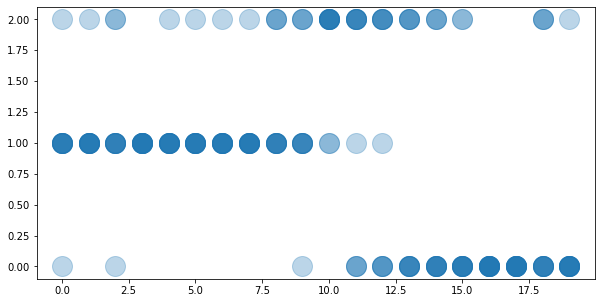

In [228]:
plt.scatter(cloud1.target_dino, cloud1.response, alpha = .3, s=400)
plt.show()

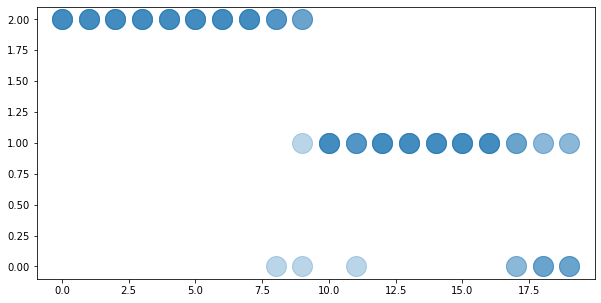

In [176]:
plt.scatter(cloud2.target_dino, cloud2.response, alpha = .3, s=400)
plt.show()

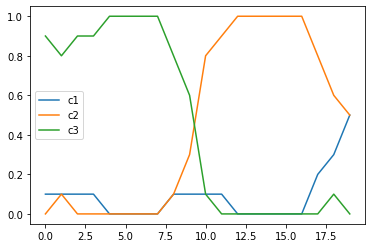

[26.80555556 18.39010989  4.8021978 ]
[12.61111111 13.78021978  4.6043956 ]


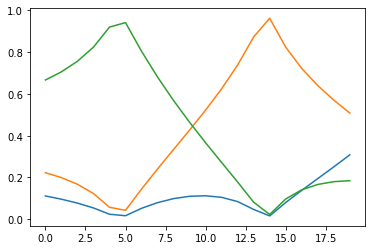

[[0.01646603 0.04240386 0.94113011]
 [0.01553296 0.96196493 0.0225021 ]]
[[0.11110664 0.22262183 0.66627153]
 [0.10956039 0.4265579  0.46388172]
 [0.11207336 0.52212213 0.36580451]
 [0.30789277 0.50793304 0.18417419]]


In [543]:
cloud=responses_test
cloud_dict={}
for i in range(20):
    cloud_dict[i]=[0, 0, 0]
for i in range(len(cloud.target_dino)):
    cloud_dict[int(list(cloud.target_dino)[i])][list(cloud.response)[i]]+=1
class1 = [cloud_dict[i][0]/sum(cloud_dict[i]) for i in range(20)]
class2 = [cloud_dict[i][1]/sum(cloud_dict[i]) for i in range(20)]
class3 = [cloud_dict[i][2]/sum(cloud_dict[i]) for i in range(20)]
plt.plot(list(range(20)),class1, label='c1')
plt.plot(list(range(20)),class2, label='c2')
plt.plot(list(range(20)),class3, label='c3')
plt.legend()
plt.show()
mp1=np.sum(class1*np.array(range(20)))/np.sum(class1)
mp2=np.sum(class2*np.array(range(20)))/np.sum(class2)
mp3=np.sum(class3*np.array(range(20)))/np.sum(class3)
mean_peaks=np.array([mp1,mp2,mp3])

def peaks(lab1, lab2):
    diffs = lab2-lab1
    shift=(1-lab2)/diffs
    shift[diffs==0]=-0.5
    return 14+(shift*(14-5))
peaks(*sl[num])
print((mean_peaks+peaks(*sl[num]))/2)
print(mean_peaks)
from soft_knn import SoftKNN, softmax

clf=SoftKNN(k=3)
prototype_loc = mean_peaks+[15,0,0]#np.array([18,13.7,4.6])
prototype_lab = np.array([np.array([1., 0., 0.]), np.array([0.,1.,0.]), np.array([0.,0.,1.])])
clf.fit(prototype_loc, prototype_lab)
x=np.linspace(0,19, 20)
preds=clf.probabilities(x)
plt.plot(x,preds)
plt.show()
print(clf.probabilities([5,14]))
print(clf.probabilities([0,9,10,19]))

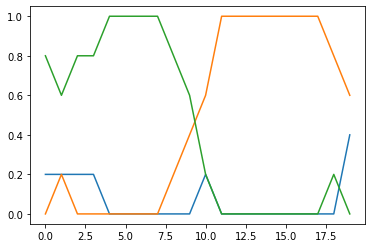

7.714285714285715
13.795918367346939
5.000000000000001


In [514]:
cloud1_dict={}
for i in range(20):
    cloud1_dict[i]=[0, 0, 0]
for i in range(len(cloud1.target_dino)):
    cloud1_dict[int(list(cloud1.target_dino)[i])][list(cloud1.response)[i]]+=1
class1 = [cloud1_dict[i][0]/sum(cloud1_dict[i]) for i in range(20)]
class2 = [cloud1_dict[i][1]/sum(cloud1_dict[i]) for i in range(20)]
class3 = [cloud1_dict[i][2]/sum(cloud1_dict[i]) for i in range(20)]
plt.plot(list(range(20)),class1)
plt.plot(list(range(20)),class2)
plt.plot(list(range(20)),class3)
plt.show()
print(np.sum(class1*np.array(range(20)))/np.sum(class1))
print(np.sum(class2*np.array(range(20)))/np.sum(class2))
print(np.sum(class3*np.array(range(20)))/np.sum(class3))

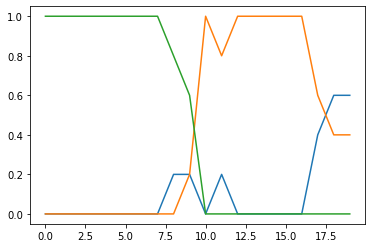

15.727272727272727
13.761904761904761
4.234042553191489


In [515]:
cloud2_dict={}
for i in range(20):
    cloud2_dict[i]=[0, 0, 0]
for i in range(len(cloud2.target_dino)):
    cloud2_dict[int(list(cloud2.target_dino)[i])][list(cloud2.response)[i]]+=1
class1 = [cloud2_dict[i][0]/sum(cloud2_dict[i]) for i in range(20)]
class2 = [cloud2_dict[i][1]/sum(cloud2_dict[i]) for i in range(20)]
class3 = [cloud2_dict[i][2]/sum(cloud2_dict[i]) for i in range(20)]
plt.plot(list(range(20)),class1)
plt.plot(list(range(20)),class2)
plt.plot(list(range(20)),class3)
plt.show()
print(np.sum(class1*np.array(range(20)))/np.sum(class1))
print(np.sum(class2*np.array(range(20)))/np.sum(class2))
print(np.sum(class3*np.array(range(20)))/np.sum(class3))

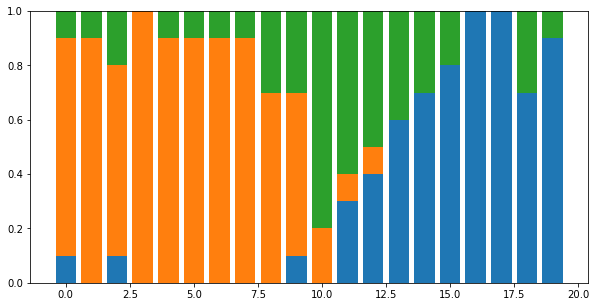

In [151]:
cloud1_dict={}
for i in range(20):
    cloud1_dict[i]=[0, 0, 0]
for i in range(len(cloud1.target_dino)):
    cloud1_dict[int(list(cloud1.target_dino)[i])][list(cloud1.response)[i]]+=1
class1 = np.array([cloud1_dict[i][0]/sum(cloud1_dict[i]) for i in range(20)])
class2 = np.array([cloud1_dict[i][1]/sum(cloud1_dict[i]) for i in range(20)])
class3 = np.array([cloud1_dict[i][2]/sum(cloud1_dict[i]) for i in range(20)])
plt.bar(list(range(20)),class1)
plt.bar(list(range(20)),class2, bottom=class1)
plt.bar(list(range(20)),class3, bottom=class1+class2)
plt.show()

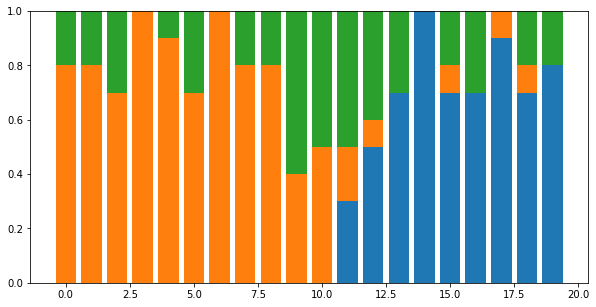

In [152]:
cloud2_dict={}
for i in range(20):
    cloud2_dict[i]=[0, 0, 0]
for i in range(len(cloud2.target_dino)):
    cloud2_dict[int(list(cloud2.target_dino)[i])][list(cloud2.response)[i]]+=1
class1 = np.array([cloud2_dict[i][0]/sum(cloud2_dict[i]) for i in range(20)])
class2 = np.array([cloud2_dict[i][1]/sum(cloud2_dict[i]) for i in range(20)])
class3 = np.array([cloud2_dict[i][2]/sum(cloud2_dict[i]) for i in range(20)])
plt.bar(list(range(20)),class1)
plt.bar(list(range(20)),class2, bottom=class1)
plt.bar(list(range(20)),class3, bottom=class1+class2)
plt.show()

In [99]:
def plot_softlabel_data(all_responses, cloud, label_pair, dataframe):
#     fig, ax = plt.subplots()
    
#     x = np.arange(20)
#     width = 0.35 
    
#     rects1 = ax.bar(x - width/2, [1,2], width, label='Men')
#     rects2 = ax.bar(x + width/2, [3,4], width, label='Women')
    
#     plt.show()

    labels = ['G1', 'G2', 'G3', 'G4', 'G5']
    men_means = [20, 34, 30, 35, 27]
    women_means = [25, 32, 34, 20, 25]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, men_means, width, label='Men')
    rects2 = ax.bar(x + width/2, women_means, width, label='Women')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('Scores by group and gender')
    ax.set_xticks(x, labels)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()

In [ ]:
plot_softlabel_data(None, None, None, None)